In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ilyasstrougouty","key":"8f52a7578dedff45b83ca2fbd996cce9"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Download the dataset from Kaggle
!kaggle datasets download -d shlokraval/ppe-dataset-yolov8

# Unzip the file
!unzip -q ppe-dataset-yolov8.zip -d ppe_dataset

Dataset URL: https://www.kaggle.com/datasets/shlokraval/ppe-dataset-yolov8
License(s): apache-2.0
100% 2.35G/2.35G [00:21<00:00, 141MB/s]
100% 2.35G/2.35G [00:21<00:00, 118MB/s]


In [5]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.5 MB/s eta 0:00:00


**1. Install & Import Libraries**

In [10]:
!pip install pyyaml seaborn

import os
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter, defaultdict
import cv2
import random

print("Libraries imported successfully.")

Libraries imported successfully.


**2. Setup: Load Configuration**

In [8]:
# --- 1. Define Paths ---
#Paths inside Colab session
label_folder = "/content/ppe_dataset/train/labels"
img_folder = "/content/ppe_dataset/train/images"
yaml_path = "/content/ppe_dataset/data.yaml"

In [9]:
# --- 2. Load Class Names from YAML ---
class_names = []
name_to_id = {}
try:
    with open(yaml_path, 'r') as f:
        data_yaml = yaml.safe_load(f)
        class_names = data_yaml['names']
        print(class_names)
        # Create a reverse map: {'GLOVE': 0, 'Goggles': 1, ...}
        name_to_id = {name: i for i, name in enumerate(class_names)}
    print(f"Successfully loaded {len(class_names)} classes from data.yaml")
except Exception as e:
    print(f"FATAL ERROR: Could not read {yaml_path}: {e}")

['Fall-Detected', 'Gloves', 'Goggles', 'Hardhat', 'Ladder', 'Mask', 'NO-Gloves', 'NO-Goggles', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest', 'Person', 'Safety Cone', 'Safety Vest']
Successfully loaded 14 classes from data.yaml


In [11]:
# --- 3. Define Class Groups for Analysis ---
# We map the positive class to its negative counterpart
ppe_pairs = {
    'Hardhat': 'NO-Hardhat',
    'Gloves': 'NO-Gloves',
    'Goggles': 'NO-Goggles',
    'Mask': 'NO-Mask',
    'Safety Vest': 'NO-Safety Vest'
}

# Get the class IDs for all these items
try:
    PERSON_ID = name_to_id['Person']
    FALL_ID = name_to_id['Fall-Detected']

    # Get IDs for all PPE pairs
    ppe_pair_ids = {}
    for pos, neg in ppe_pairs.items():
        if pos in name_to_id and neg in name_to_id:
            ppe_pair_ids[name_to_id[pos]] = name_to_id[neg]

    print(f"Tracking {len(ppe_pair_ids)} PPE pairs.")
    print(f"Person ID: {PERSON_ID}, Fall-Detected ID: {FALL_ID}")

except KeyError as e:
    print(f"FATAL ERROR: A required class {e} is missing from data.yaml. Analysis cannot continue.")

Tracking 5 PPE pairs.
Person ID: 11, Fall-Detected ID: 0


**3. Main Analysis Loop**

In [12]:
# Initialize all our counters before the loop
# Analysis 1: Overall count of every object
class_instance_counts = Counter()

# Analysis 2: Per-image content
images_with_person = 0
images_with_person_and_violation = 0
images_with_fall = 0

# Analysis 3: Co-occurrence matrix
# defaultdict(int) creates a dictionary where new keys default to 0
co_occurrence = defaultdict(int)
total_labeled_images = 0

file_list = os.listdir(label_folder)
print(f"Starting analysis of {len(file_list)} label files...")

for filename in file_list:
    if not filename.endswith(".txt"):
        continue

    total_labeled_images += 1
    label_path = os.path.join(label_folder, filename)

    # This set will store all unique class IDs found IN THIS FILE
    class_ids_in_this_file = set()

    with open(label_path, 'r') as f:
        for line in f:
            try:
                class_id = int(line.split()[0])

                # --- Analysis 1: Overall Class Counts ---
                class_instance_counts[class_id] += 1

                # Add to the set for this file
                class_ids_in_this_file.add(class_id)

            except Exception:
                continue # Skip malformed line

    # --- Analysis 2: Person-Centric & Event Analysis ---
    has_person = PERSON_ID in class_ids_in_this_file
    has_fall = FALL_ID in class_ids_in_this_file

    if has_person:
        images_with_person += 1

    if has_fall:
        images_with_fall += 1

    # Check if a person is in the image *with* any violation
    has_violation = False
    for violation_id in ppe_pair_ids.values():
        if violation_id in class_ids_in_this_file:
            has_violation = True
            break # Found a violation, no need to check more

    if has_person and (has_violation or has_fall):
        images_with_person_and_violation += 1

    # --- Analysis 3: Co-occurrence Matrix ---
    # Convert set to sorted list to create unique pairs
    sorted_ids = sorted(list(class_ids_in_this_file))
    for i in range(len(sorted_ids)):
        for j in range(i, len(sorted_ids)):
            id_1 = sorted_ids[i]
            id_2 = sorted_ids[j]
            # Create a unique key for the pair (class_1_name, class_2_name)
            pair_key = tuple(sorted((class_names[id_1], class_names[id_2])))
            co_occurrence[pair_key] += 1

print(f"...Analysis loop complete. Processed {total_labeled_images} images.")


Starting analysis of 30765 label files...
...Analysis loop complete. Processed 30765 images.


**4. Result 1: Overall Class Distribution**


--- Analysis 1: Overall Class Distribution ---


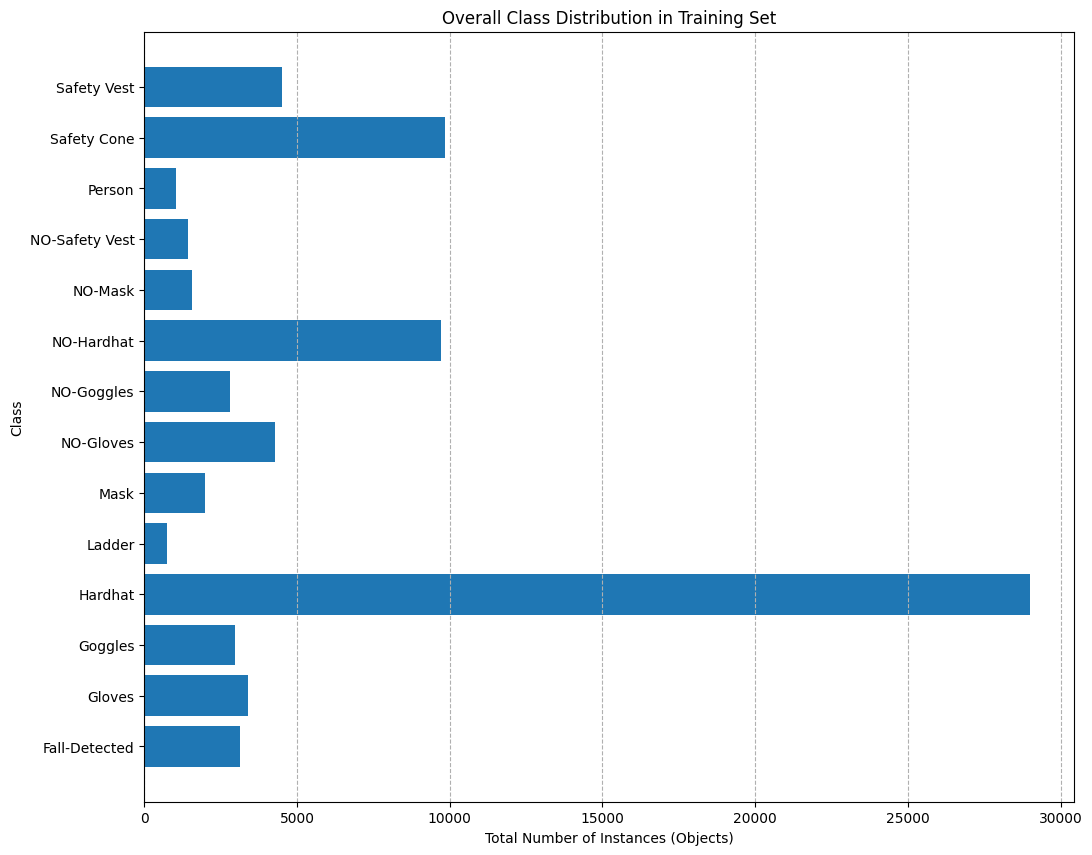

In [13]:
# --- Display Results: Analysis 1 (Class Distribution) ---
print("\n--- Analysis 1: Overall Class Distribution ---")
if class_instance_counts:
    # Sort counts for plotting
    sorted_counts = {k: v for k, v in sorted(class_instance_counts.items())}

    labels = [class_names[i] for i in sorted_counts.keys()]
    counts = list(sorted_counts.values())

    plt.figure(figsize=(12, 10))
    plt.barh(labels, counts) # Horizontal bar chart is easier to read
    plt.xlabel("Total Number of Instances (Objects)")
    plt.ylabel("Class")
    plt.title("Overall Class Distribution in Training Set")
    plt.grid(axis='x', linestyle='--')
    plt.show()
else:
    print("No class instances were counted.")

**What This Means For Our Model:**

The model will learn to find **Hardhats** very, very well.

You will get good compliance models for all PPE types because you have a strong mix of "good" and "bad" examples.

The biggest problem is the **low Person count**. A safety model needs to find people. We should check the Person & Event Analysis (Result 2) to see how many images even have a person. This low count is the main thing to worry about.

**5. Result 2: PPE Compliance & Safety Analysis (The Numbers)**

In [14]:
# --- Display Results: Analysis 2 (Compliance & Safety) ---
print("\n--- Analysis 2: PPE Compliance & Safety Analysis ---")

print("\n--- PPE Compliance Ratios (Total Instances) ---")
for pos_id, neg_id in ppe_pair_ids.items():
    pos_name = class_names[pos_id]
    neg_name = class_names[neg_id]

    pos_count = class_instance_counts.get(pos_id, 0)
    neg_count = class_instance_counts.get(neg_id, 0)
    total = pos_count + neg_count

    if total > 0:
        print(f"Compliance for '{pos_name}':")
        print(f"  {pos_name}: {pos_count} instances ({pos_count/total:.1%})")
        print(f"  {neg_name}: {neg_count} instances ({neg_count/total:.1%})")
    else:
        print(f"No instances found for {pos_name} or {neg_name}.")

print("\n--- Person & Event Analysis (Per Image) ---")
print(f"Total labeled images: {total_labeled_images}")
print(f"Images with a 'Fall-Detected' event: {images_with_fall}")
print(f"Images with a 'Person': {images_with_person}")
if images_with_person > 0:
    at_risk_percent = (images_with_person_and_violation / images_with_person) * 100
    print(f"Images with a 'Person' AND a violation: {images_with_person_and_violation} ({at_risk_percent:.1f}% of people are at risk)")


--- Analysis 2: PPE Compliance & Safety Analysis ---

--- PPE Compliance Ratios (Total Instances) ---
Compliance for 'Hardhat':
  Hardhat: 28996 instances (74.9%)
  NO-Hardhat: 9705 instances (25.1%)
Compliance for 'Gloves':
  Gloves: 3381 instances (44.1%)
  NO-Gloves: 4280 instances (55.9%)
Compliance for 'Goggles':
  Goggles: 2959 instances (51.2%)
  NO-Goggles: 2817 instances (48.8%)
Compliance for 'Mask':
  Mask: 1989 instances (55.8%)
  NO-Mask: 1577 instances (44.2%)
Compliance for 'Safety Vest':
  Safety Vest: 4499 instances (75.8%)
  NO-Safety Vest: 1435 instances (24.2%)

--- Person & Event Analysis (Per Image) ---
Total labeled images: 30765
Images with a 'Fall-Detected' event: 3148
Images with a 'Person': 679
Images with a 'Person' AND a violation: 0 (0.0% of people are at risk)


This dataset is not a **"person safety"** dataset. It's an **"object-counting"** dataset. It will be good at counting how many **helmets** are on a site, but it will be impossible for it to build a **"person-at-risk"** detector. This is a major limitation of this dataset.

**6. Result 3: Co-occurrence Heatmap**


--- Analysis 3: Co-occurrence Heatmap ---
Building heatmap... (this may take a moment)


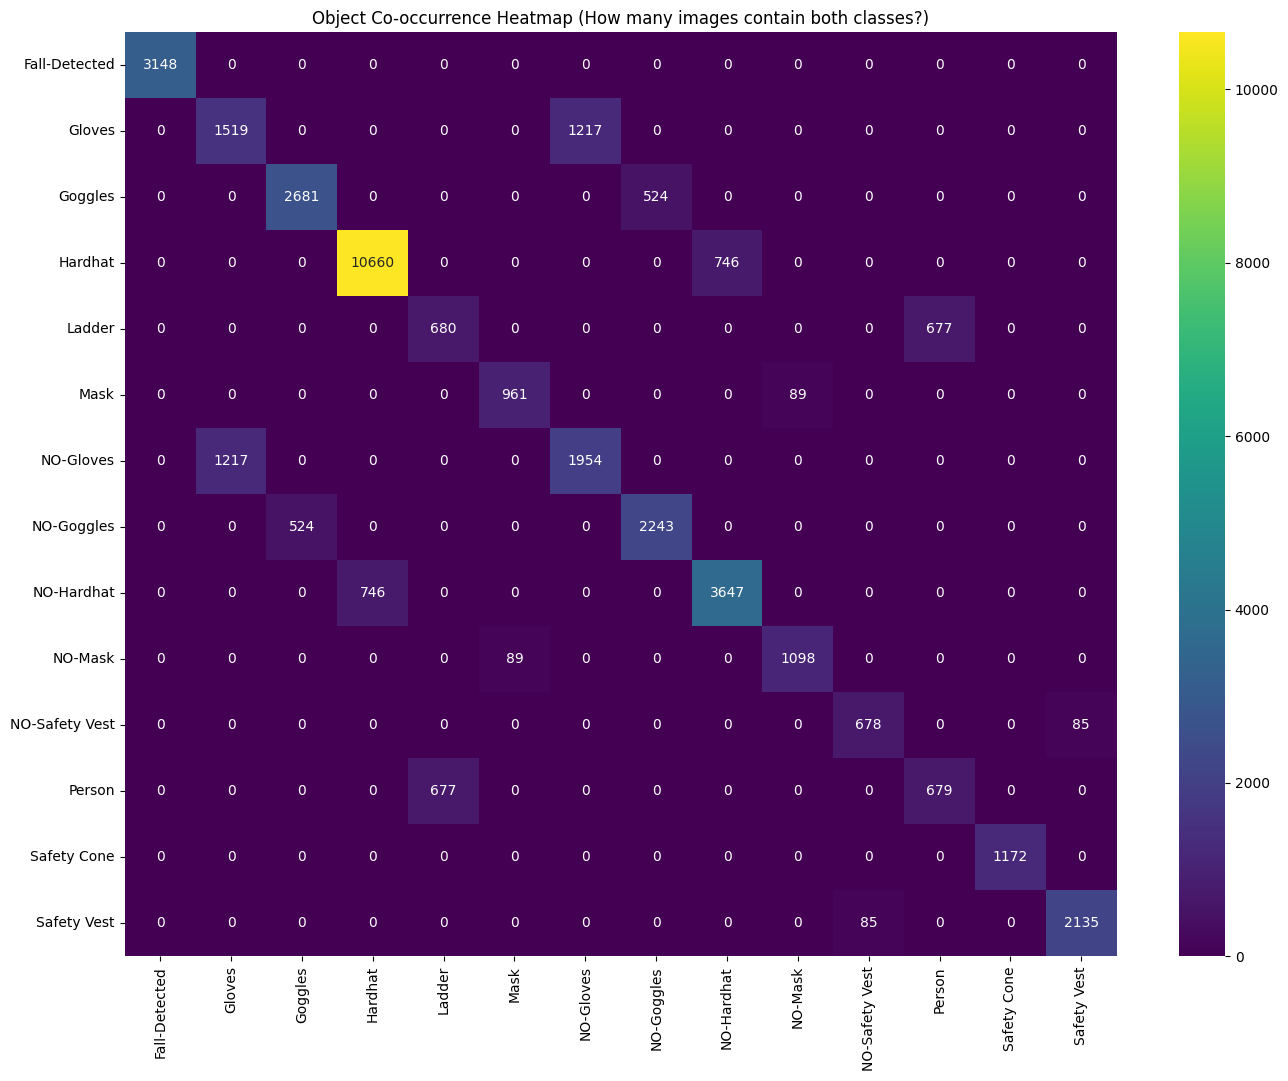

In [15]:
# --- Display Results: Analysis 3 (Co-occurrence Heatmap) ---
print("\n--- Analysis 3: Co-occurrence Heatmap ---")
print("Building heatmap... (this may take a moment)")

# Convert the co_occurrence dictionary to a DataFrame
# This is a bit complex but creates the matrix
all_names = sorted(list(class_names))
num_classes = len(all_names)
matrix = pd.DataFrame(0, index=all_names, columns=all_names)

for (class_1, class_2), count in co_occurrence.items():
    matrix.loc[class_1, class_2] = count
    if class_1 != class_2:
        matrix.loc[class_2, class_1] = count

# Plot the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(matrix, annot=True, fmt='d', cmap='viridis')
plt.title('Object Co-occurrence Heatmap (How many images contain both classes?)')
plt.show()


**7. Result 4: Visual Sanity Check**


--- Analysis 4: Visual Sanity Check ---
Displaying random image: pos_1843_jpg.rf.2a8590e2568ccd04c607af047462e20d.jpg


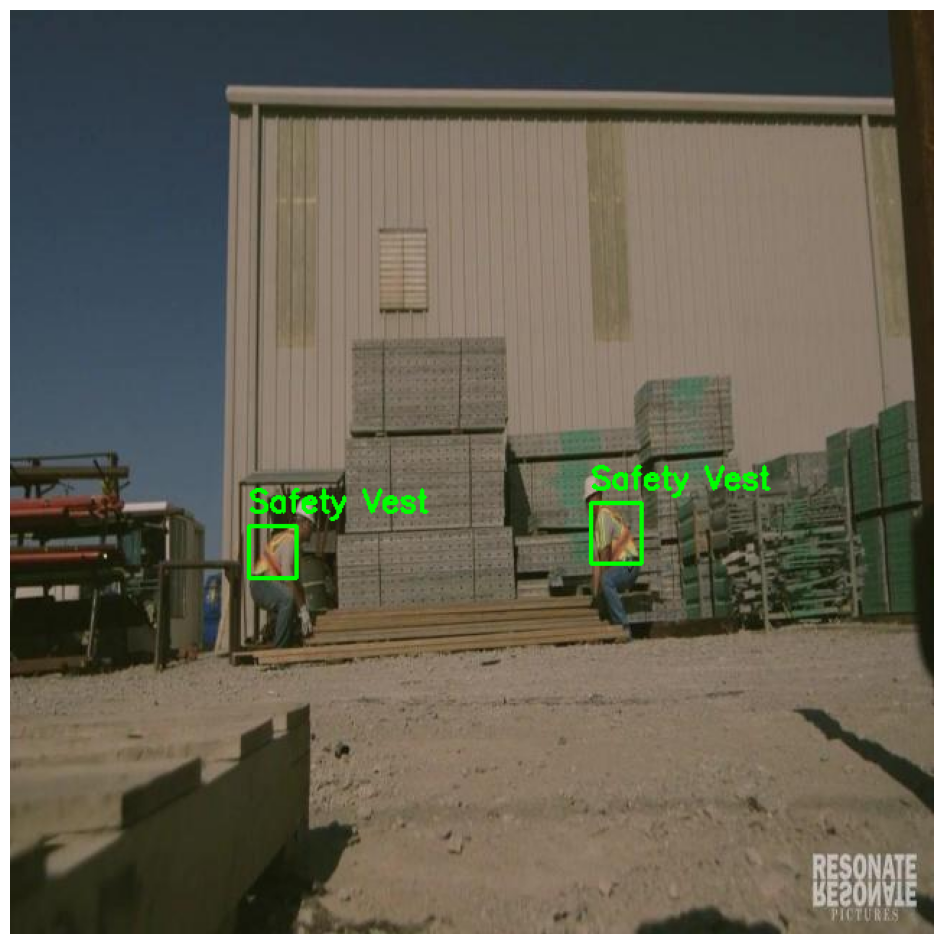

In [16]:
# --- Display Results: Analysis 4 (Visual Sanity Check) ---
print("\n--- Analysis 4: Visual Sanity Check ---")

if class_names:
    # Pick a random image
    random_image_name = random.choice(os.listdir(img_folder))
    image_path = os.path.join(img_folder, random_image_name)
    label_path = os.path.join(label_folder, random_image_name.replace('.jpg', '.txt').replace('.png', '.txt'))

    # Load image with OpenCV
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    print(f"Displaying random image: {random_image_name}")

    # Load and draw labels
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                class_id, x_c, y_c, w_norm, h_norm = map(float, line.split())

                # Denormalize coordinates
                x1 = int((x_c - w_norm/2) * w)
                y1 = int((y_c - h_norm/2) * h)
                x2 = int((x_c + w_norm/2) * w)
                y2 = int((y_c + h_norm/2) * h)

                # Draw box and label
                class_name = class_names[int(class_id)]
                # Simple color-coding: green for compliance, red for violation
                color = (0, 255, 0) # Green
                if 'NO-' in class_name or 'Fall' in class_name:
                    color = (255, 0, 0) # Red

                cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
                cv2.putText(image, class_name, (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

    # Show the image
    plt.figure(figsize=(12, 12))
    plt.imshow(image)
    plt.axis('off')
    plt.show()
else:
    print("Cannot run visual check, class names not loaded.")